# Carbon dioxide satellite observations completeness assessment for greenhouse gas monitoring

Production date: 03-09-2024

Produced by: Consiglio Nazionale delle Ricerche ([CNR](https://www.cnr.it/en))

## 🌍 Use case: Using satellite observations for quantifying global trends in greenhouse gas concentrations

## ❓ Quality assessment question
* **How the variability of spatial and temporal data coverage can affect the quantification of the long-term atmospheric carbon dioxide trends by satellite measurements (XCO2 Level 3 gridded product)?**

Carbon dioxide (CO2) is the most important anthropogenic greenhouse gas, representing about 64% of the total radiative forcing by long living greenhouse gases [[1]](https://library.wmo.int/viewer/68532/?offset=#page=4&viewer=picture&o=bookmarks&n=0&q=): in 2022, atmospheric CO2 represented the 150% of the pre-industrial level. In this assessment, atmospheric CO2 spatial seasonal means and trends are analysed using the XCO2 v4.4 Level 3 gridded product (OBS4MIPS)[[2]](http://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_PUGS_GHG_main_latest.pdf), by adopting an approach similar to [[3]](https://amt.copernicus.org/articles/13/789/2020/).

Code is included for transparency but also learning purposes and gives users the chance to adapt the code used for the assesment as they wish. Since this assessment is an experimental product, users are referred to official sources for accurate reporting (e.g., [[4]](https://climate.copernicus.eu/esotc/2023), [[5]](https://climate.copernicus.eu/global-climate-highlights-2023)). 

## 📢 Quality assessment statements

```{admonition} These are the key outcomes of this assessment
:class: note
* The dataset "Carbon dioxide data from 2002 to present derived from satellite observations" can be used to evaluate CO2 mean values, climatology and growth rate over the globe, hemispheres or large regions
* Caution should be exercised in certain regions (high latitudes, regions with frequent cloud cover, oceans) where data availability varies along the temporal coverage of the data set: this must be carefully considered when evaluating global or hemispheric information
* For data in high latitude regions or in regions with frequent cloud cover, users should consult uncertainty and quality flags as appropriate for their applications. In addition, for the years 2003-2008 only values over land are available, which has to be taken into account for possible applications of this dataset
```

## 📋 Methodology

**Spatial seasonal means and trends** are presented and assessed using the new **XCO2 v4.4 Level 3 gridded product (OBS4MIPS)** [[6]](https://cds-beta.climate.copernicus.eu/datasets/satellite-carbon-dioxide?tab=overview), which has been generated using the Level 2 EMMA products [[2]](http://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_PUGS_GHG_main_latest.pdf) as input. 

**To show how data coverage varies between years and seasons**, we have calculated and plotted the **average XCO2 values for singular seasons and years**.

**Spatial trends** are calculated using a linear model (i.e. Theil-Sen slope estimator) over monthly anomalies (i.e. actual monthly values minus climatological monthly means). **This should be treated with caution as the long-term trend of atmospheric CO2 is not strictly linear**. The statistical significance of the trends is assessed using the Mann-Kendall test. Similar to [[3]](https://amt.copernicus.org/articles/13/789/2020/), only land pixels are considered to avoid artefacts related to different data availability over oceans (the data product is land only for 2003-2008).

'The analysis and results are organised in the following steps, which are detailed in the sections below:' 

**[](template:section-1)**
 * Import all the relevant packages.
 * Choose the temporal and spatial coverage, land mask.
 * Cache needed functions.

**[](template:section-2)**
 * In this section, we define the data request to CDS. *Please note that users have to accept the GHG-CCI Licence for getting the dataset (see [[6]](https://cds-beta.climate.copernicus.eu/datasets/satellite-carbon-dioxide?tab=overview)).*

**[](template:section-3)**
 * To show how data coverage varies between years and seasons, we have plotted spatial average XCO2 values for seasons and years. Seasons are defined as December - February (DJF), March - May (MAM), June - August (JJA) and September – November  (SON).

**[](template:section-4)**
 * Trends are calculated using a linear model (i.e. Theil-Sen slope estimator) over monthly anomalies (i.e. actual monthly values minus climatological monthly means). The statistical significance of the trends is assessed using the Mann-Kendall test.

**[](template:section-5)**
 * Here main results are summarised
 
Please note that **no data sub-setting or selection has been performed**, neither as a function of the number of individual Level 2 observations leading to the reported Level 3 values ("co2_nobs"), nor as a function of the standard error ("xco2_stderr") provided in the data files.

## 📈 Analysis and results

(template:section-1)=
### 1. Choose the data to use and set-up the code

#### Import all the relevant packages
In this section, we import all the relevant packages needed for running the notebook.

In [5]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils
from xarrayMannKendall import Mann_Kendall_test

plt.style.use("seaborn-v0_8-notebook")
plt.rcParams["hatch.linewidth"] = 0.5 

#### Choose temporal and spatial coverage, land mask
In this section, we define the parameters to be ingested by the code (users can change the temporal periods of analyses, the region of interest and activate/deactivate the land masking). With the aim to compare our results with existing literature [[7]](https://library.wmo.int/records/item/58743-no-18-26-october-2022), the analysis is limited to time period  from 2012 to 2021. However, specific data subsetting can be set by the users, so that data can be also retrived for other specific periods or regions.

In [6]:
# Choose variable (xch4 or xco2)
variable = "xco2"
assert variable in [
    f"{prefix}{suffix}"
    for prefix in ("xch4", "xco2")
    for suffix in ("", "_nobs", "_stderr", "_stddev")
]

# Choose a time period
year_start = 2012
year_stop = 2021

# Minimum value of land fraction used for masking
#min_land_fraction = None  # None: Do not apply mask
min_land_fraction = 0.5 ## only use data where land_fraction >= 0.5

# Define region for analysis
lon_slice = slice(-180, 180)
lat_slice = slice(-90, 90)

#### Chache needed functions
In this section, we cached a list of functions used in the analyses.

- The function `get_da` (`get_da_nomask`) is used to subset the data for the defined time period and spatial region by applying (not appliyng) land mask (as a function of  *min_land_fraction*).

- The function `convert_units` rescale xco2 mole fraction to part per millions (ppm).

- The `seasonal_weighted_mean` function extracts the regional means over the selected domains. It uses spatial weighting to account for the latitudinal dependence of the grid size in the lon-lat grids used for the reanalysis and for the forecast models. It is used by the function `compute_seasonal_timeseries_nomask` to provide the seasonal xco2 averaged value for each single year (Figure 1). 

- The function `compute_anomaly_trends` is used to calculate the trend and the related statistical significance. 

- The `compute_monthly_anomalies` function is used to derive the monthly xco2 anomalies before calculating the trends.

In [7]:
transform_func_kwargs = {
    "min_land_fraction": min_land_fraction,
    "variable": variable,
    "year_start": year_start,
    "year_stop": year_stop,
    "lon_slice": lon_slice,
    "lat_slice": lat_slice,
}

transform_func_kwargs_nommask = {
    "year_start": year_start,
    "year_stop": year_stop,
}

def get_da(
    ds, min_land_fraction, variable, year_start, year_stop, lon_slice, lat_slice
):
    da = ds[variable].sel(time=slice(str(year_start), str(year_stop)))
    da = utils.regionalise(da, lon_slice=lon_slice, lat_slice=lat_slice)
    if min_land_fraction is not None:
        return da.where(ds["land_fraction"] >= min_land_fraction)
    return da

def get_da_nomask(ds, year_start, year_stop):
    mask = (ds["time"].dt.year >= year_start) & (ds["time"].dt.year <= year_stop)
    ds = ds.where(mask.compute(), drop=True)
    (varname,) = set(ds.data_vars) & {"xco2"}
    da = ds[varname]
    return da

def convert_units(da):
    if da.name.endswith("_nobs"):
        return da

    with xr.set_options(keep_attrs=True):
        if da.name.startswith("xch4") and da.attrs["units"] != "ppb":
            da *= 1.0e9
            da.attrs["units"] = "ppb"
        elif da.name.startswith("xco2") and da.attrs["units"] != "ppm":
            da *= 1.0e6
            da.attrs["units"] = "ppm"
    return da


def compute_seasonal_timeseries_nomask(ds, year_start, year_stop):
    # Shift years (shift -1 to get D(year-1)J(year)F(year))
    da = get_da_nomask(ds, year_start, year_stop)
    da = da.assign_coords(year=ds["time"].dt.year.shift(time=-1).astype(int))
    # Get rid of 1st JF and last D, so it become [MAM, JJA, SON, DJF, ..., SON]
    da = da.isel(time=slice(2, -1))
    da = da.groupby("year").map(diagnostics.seasonal_weighted_mean)
    return convert_units(da).to_dataset()


def compute_statistics(ds, **get_da_kwargs):
    da = get_da(ds, **get_da_kwargs)
    da = diagnostics.spatial_weighted_statistics(da)
    return convert_units(da).to_dataset()


def compute_monthly_anomalies(ds, **get_da_kwargs):
    da = get_da(ds, **get_da_kwargs)
    with xr.set_options(keep_attrs=True):
        da = da.groupby("time.month") - da.groupby("time.month").mean()
    return convert_units(da)


def compute_mann_kendall_trend(da, **mann_kendall_kwargs):
    coords_name = {"time": "time", "x": "longitude", "y": "latitude"}
    ds_trend = Mann_Kendall_test(
        da, coords_name=coords_name, **mann_kendall_kwargs
    ).compute()
    return ds_trend.rename({k: v for k, v in coords_name.items() if k != "time"})


def compute_seasonal_detrended_anomaly(da, **polyfit_kwargs):
    da_trend = xr.polyval(
        da["time"], da.polyfit("time", **polyfit_kwargs).polyfit_coefficients
    )
    da_detrended = da - da_trend
    return da_detrended.groupby("time.year").map(diagnostics.seasonal_weighted_mean)


def compute_anomaly_trends(ds, **get_da_kwargs):
    da_anomaly = compute_monthly_anomalies(ds, **get_da_kwargs)

    # Mann-Kendall
    ds_mann_kendall = compute_mann_kendall_trend(
        da_anomaly, alpha=0.05, method="theilslopes"
    ).where(da_anomaly.notnull().any("time"))
    ds_mann_kendall["trend"].attrs = {
        "long_name": f"Trend of anomalies of {da_anomaly.attrs.get('long_name', da_anomaly.name)}",
        "units": f"{da_anomaly.attrs['units']}/month",
    }

    # Detrended anomalies
    da_detrended = compute_seasonal_detrended_anomaly(da_anomaly, deg=1)
    da_detrended.attrs = {
        "long_name": f"Detrended of anomalies of {da_anomaly.attrs.get('long_name', da_anomaly.name)}",
        "units": f"{da_anomaly.attrs['units']}",
    }

    ds_mann_kendall["detrended_anomaly"] = da_detrended
    return ds_mann_kendall

(template:section-2)=
### 2. Retrieve XCO2 data (OBS4MIPS)
In this section, we define the data request to CDS (data product OBS4MIPS, Level 3, version 4.4, XCO2).

In [8]:
request = (
    "satellite-carbon-dioxide" if variable.startswith("xco2") else "satellite-methane",
    {
        "processing_level": "level_3",
        "variable": variable.split("_")[0],
        "sensor_and_algorithm": "merged_obs4mips",
        "version": "4.4",
        "format": "zip",
    },
)

(template:section-3)=
### 3. Compute and plot the global variability of seasonal XCO2
To show how data coverage varies between years and seasons, in this section we plot the spatial average XCO2 values for seasons and years. Seasons are defined as December - February (DJF), March - May (MAM), June - August (JJA) and September – November  (SON).

100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


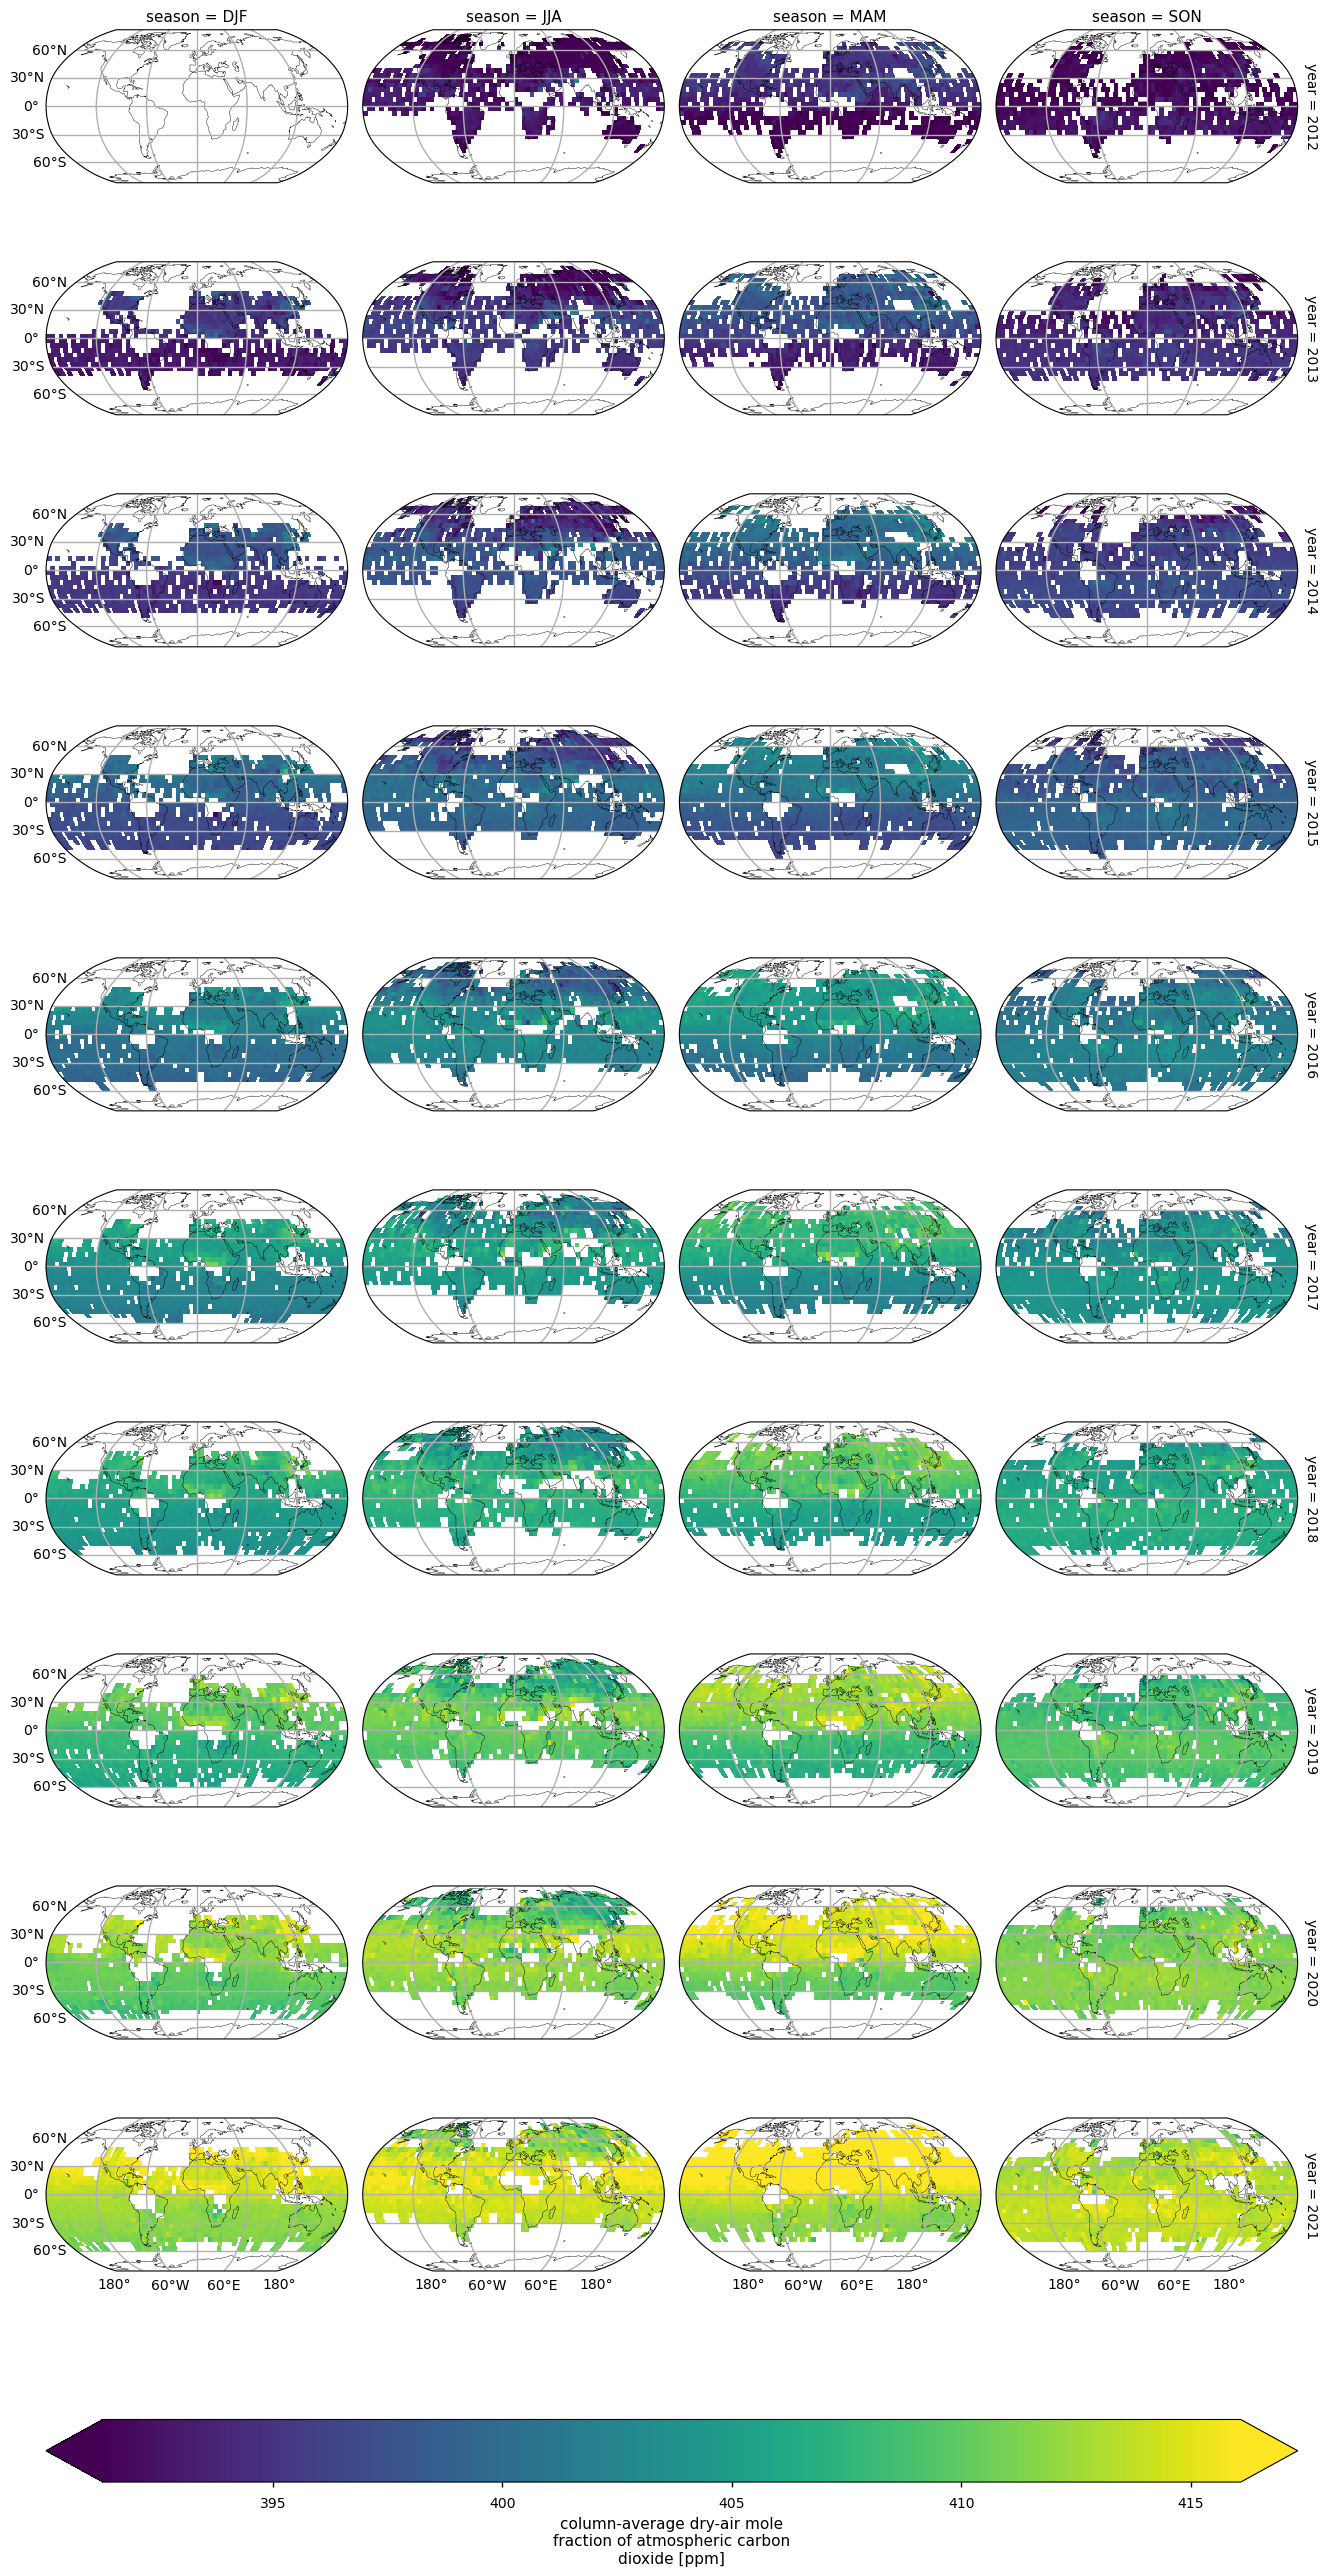

In [9]:
#Analysis of global variability of seasonal XCO2
#To invalidate the cache you can pass the argument invalidate_cache=True

ds_seasonal = download.download_and_transform(
    *request, transform_func=compute_seasonal_timeseries_nomask,transform_func_kwargs=transform_func_kwargs_nommask,
)
_ = plot.projected_map(
    ds_seasonal[variable],
    projection=ccrs.Robinson(),
    col="season",
    row="year",
    robust=True,
    cbar_kwargs={"orientation": "horizontal", "pad": 0.05},
)

*Figure 1. Global annual variability of seasonal XCO2. Different panels represent the individual seasons (column) and years (rows). Seasons are defined as December - February (DJF), March - May (MAM), June - August (JJA) and September - November (SON).*

(template:section-4)=
### 4. Compute global and spatial trends

In this section, XCO2 spatial trends are calculated and statistical significances is assessed for land pixels (“land_fraction > 0.5”). Global statistics for individual pixels are also reported as ppm/month. Please note that the low growth rates observed in the tropics are probably a result of sparse data availability due to the frequent presence of clouds.

100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


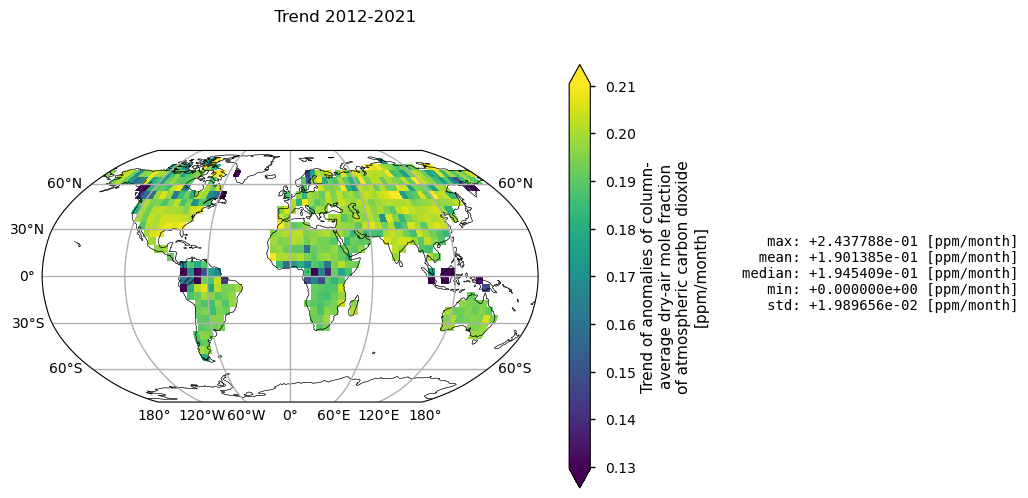

In [10]:
#Calculation of global and pixel trends
#To invalidate the cache you can pass the argument invalidate_cache=True
ds_trend = download.download_and_transform(
    *request,
    transform_func=compute_anomaly_trends,
    transform_func_kwargs=transform_func_kwargs,
)

plot.projected_map(ds_trend["trend"], robust=True, projection=ccrs.Robinson())
plot.projected_map(
    ds_trend["p"],
    plot_func="contourf",
    show_stats=False,
    cmap="none",
    add_colorbar=False,
    levels=[0, 0.05, 1],
    hatches=["", "/" * 5],
)
_ = plt.suptitle(
    f" Trend {year_start}-{year_stop}"
)

*Figure 2. Trends of XCO2 given in ppm/month calculated by using linear model (Theil-Sen) and Mann-Kendall test for statistical significance. Over each pixel, trends are calculated for monthly anomalies over land ("land_fraction > 0.5"). The shaded areas indicate pixels that did not pass the Mann-Kendall significance test. Global statistics for individual pixels are shown on the left.*

(template:section-5)=
### 5. Results

The seasonality of the availability of measurements is evident, with values available in the Southern Hemisphere (SH) mid and high latitudes from September to March, whereas values for the Northern Hemisphere (NH) mid and high latitudes are mostly available from April to August (Figure 1).

For 2012-2021, the mean global XCO2 growth rate is 2.28 ppm/yr (Figure 2). Taking into account the associated uncertainties and the different calculation methods, this value is in good agreement with the value of 2.46 ppm/yr provided by the WMO global in-situ observations [[7]](https://library.wmo.int/records/item/58743-no-18-26-october-2022). The tropics and the middle and high latitudes are the regions that are not covered by measurements throughout the year or are characterised by higher uncertainty (see also [[3]](https://amt.copernicus.org/articles/13/789/2020/)), and therefore the trend values are more variable and in some cases not statistically significant.

## ℹ️ If you want to know more

### Key resources

The CDS catalogue entries for the data used were:
* Carbon dioxide data from 2002 to present derived from satellite observations: https://cds.climate.copernicus.eu/datasets/satellite-carbon-dioxide?tab=overview

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [BOpen](https://www.bopen.eu/)

### Example of application
Copernicus Climate Change Service (C3S). (2024). [European State of the Climate 2023](https://climate.copernicus.eu/ESOTC/2023), Full report. Specifically, [the section on greenhouse gas concentrations](https://climate.copernicus.eu/esotc/2023/greenhouse-gas-concentrations).

### References
[[1]](https://library.wmo.int/viewer/68532/?offset=#page=4&viewer=picture&o=bookmarks&n=0&q=) World Meteorological Organization. (2023). WMO Greenhouse Gas Bullettin, 19, ISSN 2078-0796.

[[2]](http://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_PUGS_GHG_main_latest.pdf) Buchwitz, M. (2023). Product User Guide and Specification (PUGS) – Main document for Greenhouse Gas (GHG: CO2 & CH4) data set CDR 6 (01.2003-12.2021), C3S project 2021/C3S2_312b_Lot2_DLR/SC1, v6.3.

[[3]](https://amt.copernicus.org/articles/13/789/2020/) Reuter, M., Buchwitz, M., Schneising, O., Noël, S., Bovensmann, H., Burrows, J. P., Boesch, H., Di Noia, A., Anand, J., Parker, R. J., Somkuti, P., Wu, L., Hasekamp, O. P., Aben, I., Kuze, A., Suto, H., Shiomi, K., Yoshida, Y., Morino, I., Crisp, D., O'Dell, C. W., Notholt, J., Petri, C., Warneke, T., Velazco, V. A., Deutscher, N. M., Griffith, D. W. T., Kivi, R., Pollard, D. F., Hase, F., Sussmann, R., Té, Y. V., Strong, K., Roche, S., Sha, M. K., De Mazière, M., Feist, D. G., Iraci, L. T., Roehl, C. M., Retscher, C., and Schepers, D. (2020). Ensemble-based satellite-derived carbon dioxide and methane column-averaged dry-air mole fraction data sets (2003–2018) for carbon and climate applications. Atmospheric Measurement Techniques, 13, 789–819.

[[4]](https://climate.copernicus.eu/esotc/2023) Copernicus Climate Change Service (C3S). (2024). European State of the Climate 2023, Full report.

[[5]](https://climate.copernicus.eu/global-climate-highlights-2023) Copernicus Climate Change Service (C3S). (2024). Global Climate Highlights 2023.

[[6]](https://cds-beta.climate.copernicus.eu/datasets/satellite-carbon-dioxide?tab=overview) Copernicus Climate Change Service, Climate Data Store, (2018): "Carbon dioxide data from 2002 to present derived from satellite observations". Copernicus Climate Change Service (C3S) Climate Data Store (CDS). DOI: 10.24381/cds.f74805c8.

[[7]](https://library.wmo.int/records/item/58743-no-18-26-october-2022) World Meteorological Organization. (2022). WMO Greenhouse Gas Bullettin, 18, ISSN 2078-0796.